# Time Series Prediction (30 Points)

In this exercise, you will have a look on a different type of prediction problem: **time series prediction**.
You will implement and evaluate the commonly used time series predictor SARIMA on the dataset of positive corona tests.

In the event of a persistent problem, do not hesitate to contact the course instructors under
- paul.kahlmeyer@uni-jena.de

### Submission

- Deadline of submission:
        x.y.z
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=18310)

# Dataset

The global COVID-19 pandemic has led to the creation of enormous datasets, that let us evaluate the trend of the pandemic. 

Here we will use the daily updated [preprocessed dataset](https://www.kaggle.com/headsortails/covid19-tracking-germany) available on kaggle.
Each row in this dataset is a daily report from a german county on reported cases of COVID-19. It contains the following attributes:

- `state`: Name of german federal state (Bundesland)
- `county`: Name of county (Landkreis)
- `age_group`: age group of reported cases
- `gender`: gender of reported cases
- `date`: date of reporting
- `cases`: number of reported positive tests
- `deaths`: number of reported deaths
- `recovered`: number of reported recovered cases


In this task, we are only interested in the development of positive cases over time.

As a sanity check, you can compare your solution with the official 
[Corona Dashboard](https://experience.arcgis.com/experience/478220a4c454480e823b17327b2bf1d4) of the RKI (here a 
[faster version](https://covid-karte.de/)).

### Task 1 (7 Points)
Load and prepare the dataset into a timeline that hold the number of reported positive cases over time.
Plot the resulting timeline.

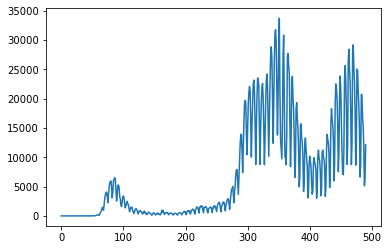

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# TODO: load data
data = pd.read_csv('covid_de.csv')
data = data.dropna()
data = data.drop(columns=['state', 'county', 'gender', 'deaths', 'recovered'])


# TODO: process data
# get unique dates (sorted)
tmp = list(set(data['date']))
tmp = sorted(tmp, key=lambda d: tuple(map(int, d.split('-'))))

# convert into dates
from datetime import date
dates = []
for d in tmp:
    year, month, day = [int(x) for x in d.split('-')]
    dates.append(date(year, month, day))

# calculate differences in days
days = [0]
for i in range(1, len(tmp)):
    delta = dates[i] - dates[i-1]
    days.append(days[-1]+delta.days)
    
#convert into dictionary
date_dict = {d:i for d,i in zip(tmp,days)}
data['date'] = data['date'].map(date_dict)

# collect all cases on a day
cases = np.array([sum(data[data['date']==i]['cases']) for i in days])

# set missing days to zero
y_t = np.zeros(days[-1]+1)
y_t[days] = cases



# TODO: plot curve
plt.plot(y_t)

# Time series prediction

The problem of predicting the next value in a time series is fundamentaly different from the prediction problems we have seen so far, as the points in a time series do naturally depend on each other. 

First, we want to introduce a baseline predictor, against which we can compare our later predictors.

### Task 2 (1 Point)

An extremely simple predictor is the **naive predictor**, that predicts the last value of a time series as the next value. Implement and test this predictor.

In [281]:
def naive(time_series):
    # TODO: return prediction of naive predictor
    return time_series[-1]

time_series = np.array([1,2,3])
naive(time_series)

3

Next, we want to introduce a quality measure that evaluates the quality of a predictor.

Let 
- $y_1,\dots,y_n$ be a time series of lenght $n$
- $m<n$ be an index of the time series
- $p_k: \mathbb{R}^k\rightarrow \mathbb{R}$ be a predictor, that predicts a next value for a given time series of length $k$
- $d(y_i,\hat{y}_i)$ be a distance measure between predicted and actual value

**Walk forward validation** for a type of predictor $p_k$ is defined as 

\begin{align}
\cfrac{1}{n-m}\sum\limits_{i=0}^{n-m-1}d\left(y_{m+i+1}, p_{m+i}\left(\left[y_j\right]_{j=1,\dots,m+i}\right)\right)
\end{align}

in other words, starting with the first $m$ steps of the time series, we determine the error of the predicted next value. We then walk one step forward in the time series (first $m+1$ steps) and repeat the process until we predicted the last value of the time series. The average prediction error is then reported as walk forward validation.

### Task 3 (3 Points)

Implement the `wfv` function, that takes as input:
- `predictor`: A function, that takes as input a time series and outputs the predicted next value
- `time series`: A time series
- `s_perc`: percentage of the time series to start the walk forward validation with
- `plot` : optional keyword, that lets you plot the predicted values vs. the actual values

and outputs the [**Mean Absolute Error**](https://en.wikipedia.org/wiki/Mean_absolute_error) between the predictions and the actual values.

Use your function to evaluate the naive predictor from Task 2.

MAE: 2276.5267175572517


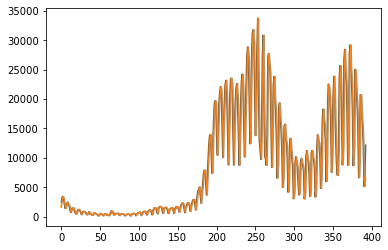

In [454]:
def wfv(predictor, time_series, s_perc=0.2, plot=False):
    size = int(len(time_series) * s_perc)
    history, target = time_series[:size], time_series[size:len(time_series)]
    preds = list()
    
    # walk-forward validation
    for t in range(len(target)):
        yhat = predictor(history)
        preds.append(yhat)
        obs = target[t]
        history = np.append(history, [obs])
    if plot:
        plt.plot(target)
        plt.plot(preds)
    return np.mean(np.abs(target-preds))

print(f'MAE: {wfv(naive, y_t, plot=True)}')

We can see, that the simple, naive predictor gets wrong, because there is an underlying seasonality within the time series.

### Task 4 (1 Point)

Implement the `naive_season` predictor, a generalization of the `naive` predictor.
It that takes an additional seasonality parameter `s` and predicts the last value of the season (e.g. if we assume a seasonality of 3 days, it would predict the value from 3 days ago).

Evaluate the `naive_season` predictor with walk forward validation and compare the result to the naive predictor (`s_perc`=0.2).

Hint: You can use a [lambda function](https://realpython.com/python-lambda/) to quickly pass a function to `wfv`.

MAE: 1573.4071246819337


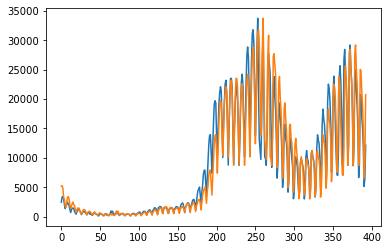

In [455]:
def naive_season(time_series, s=1):
    return time_series[-s]
print(f'MAE: {wfv(lambda x: naive_season(x,7), y_t, plot=True)}')

# SARIMA

SARIMA models are a widely used approach for time series prediction. The general approach is to predict the next value by explaining auto-correlations in the time series.

The name SARIMA is an acronym and stands for Seasonal AutoRegressive Integrated Moving Average.

In order to make a prediction, one has to perform five steps:

1. Make the time series stationary (**S,I**)
2. Estimate the AutoRegressive Model using OLS (**AR**)
3. Estimate the Moving Average Model using OLS (**MA**)
4. Predict the next stationary value using 2. and 3.
5. Make prediction unstationary again

For further information, see [here](https://otexts.com/fpp2/arima.html).

## Make the time series stationary

Since we have a time series, the values do strongly depend on each other and we can not use any of our classical approaches, where we assumed i.i.d. data.

A stationary time series is a time series, where the value does not depend on the time anymore and is equivalent to a random walk. Thus there is no dependence among the data due to time (e.g. periodicity, trend) and we can use classical approaches.

A simple (and reversible) way of making a time series stationary is by **differenciating**.

For a given time series $y_1,\dots,y_n$, we create a new time series:
\begin{align}
y_t' = y_{t}-y_{t-s}\,
\end{align}

where the integer $s$ is a seasonality parameter.

In theory, we could differenciate the differenciated time series again, to make it even more stationary.
The number of times one differenciates the time series is set by a hyperparameter $d$.
However in practice (and especially here) it is often sufficient to set $d=1$, that is to differenciate only once.
Therefore we will ignore this possibility.

Note: If we set $s>1$, the model is called **S**ARIMA (S for seasonal).

### Task 5 (2 Points)

Implement the `differenciate` function and test it on the corona cases dataset.

Think about the dataset: Which value for $s$ makes sense?

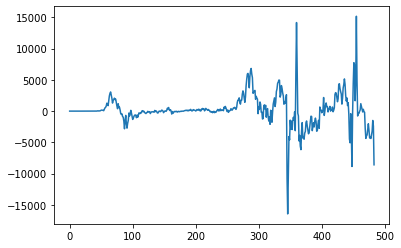

In [419]:
def differenciate(time_series, s=1):
    # TODO: differenciate the time series
    diff_series = time_series[s:]-time_series[:-s]
    return diff_series
    
# TODO: differenciate corona time series
s = 7
stat_data = differenciate(y_t, s=s)
plt.plot(stat_data)

## Auto Regressive Model

In an auto regressive model, we assume the following model
\begin{align}
y'_t &= \theta_0+\left(\sum\limits_{i=1}^{p}\theta_i y'_{t-i} \right)\\
    &= \begin{bmatrix}
    \theta_0\\
    \theta_1\\
    \vdots\\
    \theta_p
    \end{bmatrix}^T
    \begin{bmatrix}
    1\\
    y'_{t-1}\\
    \vdots\\
    y'_{t-p}
    \end{bmatrix}\,,
\end{align}

where the next value of a time series is the result of an affine combination of the previous $p$ values.

Note, how the estimation of $\theta$ corresponds to the classical OLS problem.

### Task 6 (2 Points)
In order to make an Maximum Likelhood estimation, we need a dataset of samples $\left[y'_i\right]_{i=1,\dots,p}$ and labels $y'_{p+1}$.

Implement a function `time_series_dataset`, that takes a time series `time_series` and a window parameter `k` (corresponds to $p$) as input. The output should be a dataset of all possible sample label pairs as defined above.

In [420]:
def time_series_dataset(time_series, k):
    # TODO: create time series dataset
    X = []
    Y = []
    for i in range(len(time_series)-k):
        x = time_series[i:i+k]
        X.append(x)
        y = time_series[i+k]
        Y.append(y)
    return np.stack(X), np.stack(Y)

### Task 7 (3 Points)

Implement the auto regressive model class `AR`.

After $\theta$ was estimated from a dataset, calculate the predictions
\begin{align}
\tilde{y'_t}:= \theta_0+\left(\sum\limits_{i=1}^{p}\theta_i y'_{t-i} \right)
\end{align}
and the residuals 
\begin{align}
\varepsilon_t := y'_t-\tilde{y'_t}
\end{align}
for each sample label pair of the dataset and save them as attributes of the class.

In [421]:
from sklearn.linear_model import LinearRegression
    
class AR():
    
    def __init__(self, p):
        self.p = p
        self.theta = None
        self.intercept = None
        self.predictions = None
        self.residuals = None

    def fit(self, time_series):
        # TODO: estimate theta + intercept
        X, Y = time_series_dataset(time_series, self.p)
        lr = LinearRegression().fit(X, Y)
        self.theta  = lr.coef_.T
        self.intercept = lr.intercept_
        
        # TODO: calculate residuals
        self.predictions = lr.predict(X)
        self.residuals = Y-self.predictions
        
    
    def predict(self, time_series):
        # TODO: predict next value
        return np.dot(time_series[-self.p:], self.theta)+self.intercept

### Task 8 (2 Points)

Now test your `AR` class on the stationary time series from Task 5.

1. Fit the time AR model on the whole time series
2. Plot the predictions of the AR model with the actual time series

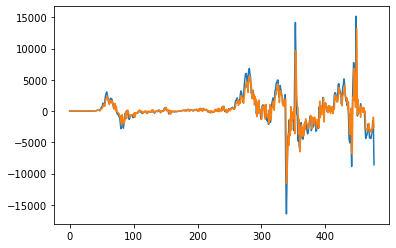

In [423]:
# TODO: Fit AR on stationary series
p = 7
ar = AR(p)
ar.fit(stat_data)

# TODO: plot predictions vs. stationary series
plt.plot(stat_data[p:])
plt.plot(ar.predictions)

## Moving Average Model

The Moving Average Model models the residual $\varepsilon_t$:
\begin{align}
\varepsilon_t &= \phi_0+\left(\sum\limits_{i=1}^{q}\phi_i \varepsilon_{t-i} \right)\\
    &= \begin{bmatrix}
    \phi_0\\
    \phi_1\\
    \vdots\\
    \phi_p
    \end{bmatrix}^T
    \begin{bmatrix}
    1\\
    \varepsilon_{t-1}\\
    \vdots\\
    \varepsilon_{t-q}
    \end{bmatrix}\,,
\end{align}

where the next residual time series is the result of an affine combination of the previous $q$ residuals.

The estimation of $\phi$ again corresponds to the classical OLS problem.


### Task 9 (2 Points)

Similar to Task 7, implement a Moving Average Model class `MA`.

Test your class on the residuals from the `AR` object of Task 8.

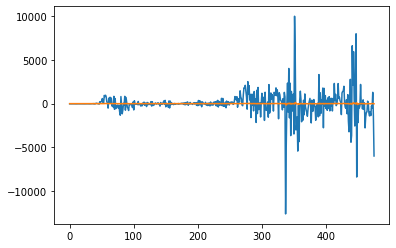

In [426]:
from sklearn.linear_model import LinearRegression
    
class MA():
    def __init__(self, q):
        self.q = q
        self.phi = None
        self.intercept = None
        self.predictions = None

    def fit(self, residual_series):
        # TODO: estimate phi + intercept
        X, Y = time_series_dataset(residual_series, self.q)
        lr = LinearRegression().fit(X, Y)
        self.phi  = lr.coef_.T
        self.intercept = lr.intercept_
        
        # TODO: calculate predictions
        self.predictions = lr.predict(X)
        

    def predict(self, residual_series):
        # TODO: predict next residual
        return np.dot(residual_series[-self.q:], self.phi)+self.intercept
    
# TODO: test class
q = 1
residuals = ar.residuals
ma = MA(q)
ma.fit(residuals)

plt.plot(residuals[q:])
plt.plot(ma.predictions)

## Combining AR and MA

The model underlying SARIMA is simply the combination of the auto regressive and the moving average model on seasonally differenciated data:
\begin{align}
y'_t = \theta_0+\left(\sum\limits_{i=1}^{p}\theta_i y'_{t-i} \right) + \phi_0+\left(\sum\limits_{i=1}^{q}\phi_i \varepsilon_{t-i} \right)
\end{align}
That is, the next value of our differenciated time series is a linear combination of the last $p$ values.
However, this value is disturbed with noise, which is a linear combination of the last $q$ residuals.

### Task 10 (4 Points)
Implement the `SARIMA` predictor function and perform the walk forward validation (`s_perc`=0.2) with this predictor.
Experiment, which values for $p,q,s$ yield good results and compare the results to the baselines.

Note, that the predicted value still has to be undifferenciated.

MAE: 846.23772158816


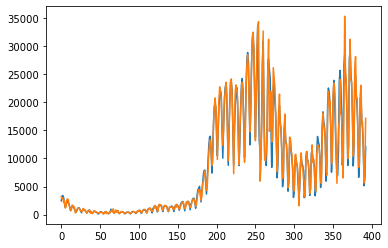

In [456]:
def SARIMA(time_series, p, q, s):
    assert len(time_series) > 2*s+p+q
    
    # TODO: differenciate
    stat_data = differenciate(time_series, s=s)
    
    # TODO: auto regressive
    ar = AR(p)
    ar.fit(stat_data)
    
    # TODO: moving average
    residuals = ar.residuals
    ma = MA(q)
    ma.fit(residuals)
    
    # TODO: combine predictions
    stat_prediction = ar.predict(stat_data[-p:]) + ma.predict(residuals[-q:])
    
    #TODO: undifferenciate
    return stat_prediction+time_series[-s]

# TODO: Test predictor
p = 7
q = 2
s = 1
print(f'MAE: {wfv(lambda x: SARIMA(x,p,q,s), y_t, plot=True)}')

## Provided Package

The Python library [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html) provides an implementation of ARIMA models.


### Task 11 (3 Points)
Use the statsmodels implementation to fit an ARIMA model on the time series and compare the walk forward validation (`s_perc`=0.2) error with the previously obtained results.

C:\Users\Paul Kahlmeyer\anaconda3\envs\MoM\lib\site-packages\statsmodels\tsa\arima\model.py:374: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "hannan_rissanen".
  warnings.warn('Provided `endog` series has been differenced'


MAE: 849.3052174182053


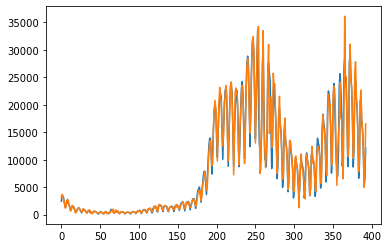

In [457]:
# TODO: define predictor using statsmodels ARIMA
from statsmodels.tsa.arima.model import ARIMA

def SARIMA_stats(history, p, q):
    model = ARIMA(history, order=(p, 1, q), enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(method='hannan_rissanen')
    return model_fit.forecast()[0]


# TODO: Test predictor
p = 7
q = 2
print(f'MAE: {wfv(lambda x: SARIMA_stats(x, p, q), y_t, plot=True)}')